## Costs

In [96]:
# Load our own functions
%load_ext autoreload
%autoreload 2
from utils.plots import *
from utils.outlier import *
from utils.partitions import *
from utils.complete_missing_dates import *
from utils.df_transformations import *

# import necesary libraries
import os
import sys

#pyspark libraries
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import unix_timestamp, from_unixtime
from pyspark.sql.functions import col , column, lit
from pyspark.sql.functions import to_date
from pyspark.sql.functions import year, month, dayofmonth
import pyspark.sql.functions as sf
from functools import reduce

#plot libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#other
import datetime
import pandas as pd
import numpy as np

# Configuration properties of Apache Spark
APP_NAME = 'pyspark_python'
MASTER = 'local[*]'

conf = SparkConf().setAppName(APP_NAME)
conf = conf.setMaster(MASTER)
spark = SparkSession.builder.config(conf = conf).getOrCreate()
sc = spark.sparkContext

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
# montly income
modelDataFile = "Data_ignore/ex1/df_income_g.csv"
df_income_g_1 = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .option("delimiter", ",") \
  .load(modelDataFile)

modelDataFile = "Data_ignore/ex2/df_income_g.csv"
df_income_g_2 = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .option("delimiter", ",") \
  .load(modelDataFile)

# montly cost
modelDataFile = "Data_ignore/ex1/df_costs_aux.csv"

df_income_g_3 = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .option("delimiter", ",") \
  .load(modelDataFile)

modelDataFile = "Data_ignore/ex2/df_costs.csv"

df_income_g_4 = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .option("delimiter", ",") \
  .load(modelDataFile)



In [53]:
dfs = [df_income_g_3, df_income_g_4] #, df_income_g_3, df_income_g_4
df_income_g = reduce(DataFrame.union, dfs)
df_income_g = (df_income_g.drop('_c0', 'g_country_id', 'gf_entity_id')
               .withColumn('account_seniority_y', col('account_seniority_m')/12)
               .sort('gf_customer_id', 'monthly_partition'))

#complete empty months
df_income_g = (df_income_g.withColumn('year', year('monthly_partition')).withColumn('month', month('monthly_partition'))
.withColumn('monthly_partition', col('monthly_partition').cast('string')))
#df_income_g = (complete_missing_months(spark, df_income_g, 'monthly_partition', 'gf_customer_id'))
df_income_g_fill = df_income_g.fillna(0)



In [54]:
df_income_g_1.count()

138

In [94]:
from pyspark.sql.types import StringType

df = df_income_g_1
df1 = df
for col_name in df.schema.names:
    if not isinstance(df.schema[col_name].dataType, StringType):
        df1 = df1.drop(col_name)
        print(col_name)

_c0
no
gf_entity_id
gf_customer_id
monthly_partition
montly_amount
year
month
account_seniority_m


In [95]:
df1.show()

+------------+
|g_country_id|
+------------+
|          ES|
|          ES|
|          ES|
|          ES|
|          ES|
|          ES|
|          ES|
|          ES|
|          ES|
|          ES|
|          ES|
|          ES|
|          ES|
|          ES|
|          ES|
|          ES|
|          ES|
|          ES|
|          ES|
|          ES|
+------------+
only showing top 20 rows



In [56]:
df_income_g_fill = (df_income_g_fill.withColumn("log_montly_amount", sf.log(col("montly_amount"))))
d_outliers_log = find_outliers(df_income_g_fill.withColumn('year', year('monthly_partition')),
                           comparison_column = 'gf_customer_id', 
                           field_value =  'log_montly_amount', #'montly_amount',
                          keep_columns = ['monthly_partition', 'montly_amount'],
                          only_outliers = False).sort('monthly_partition')
d_outliers_log = d_outliers_log.drop('year').sort('gf_customer_id', 'monthly_partition')
d_outliers_log = d_outliers_log.withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd"))

number of outliers:  7
number of Normal values:  324


In [43]:
d_outliers_log.filter('''gf_customer_id = 9987384''').drop('Hotelling', 'stddev_median').show(200, False)

+--------------+-----------------+-----------------+-------------+-----+------+--------+------+----------+----------+---------+-------------+-------------+
|gf_customer_id|log_montly_amount|monthly_partition|montly_amount|mean |median|skewness|stddev|UpperLimit|LowerLimit|isOutlier|ratio_mean_sd|ratio_sd_mean|
+--------------+-----------------+-----------------+-------------+-----+------+--------+------+----------+----------+---------+-------------+-------------+
|9987384       |10.094           |2019-07-31       |24200.0      |9.276|8.741 |0.415   |2.004 |12.281    |6.27      |false    |4.629        |0.216        |
|9987384       |6.321            |2019-08-31       |556.17       |9.276|8.741 |0.415   |2.004 |12.281    |6.27      |false    |4.629        |0.216        |
|9987384       |8.288            |2019-09-30       |3974.59      |9.276|8.741 |0.415   |2.004 |12.281    |6.27      |false    |4.629        |0.216        |
|9987384       |8.904            |2019-10-31       |7357.99     

In [27]:
d_outliers_log.drop('Hotelling', 'stddev_median').show(200, False) # = d_outliers_log.select('gf_customer_id', 'isOutlier', 'monthly_partition').withColumnRenamed('isOutlier', 'isLogOutlier')

+--------------+-----------------+-----------------+-------------+-----+------+--------+------+----------+----------+---------+-------------+-------------+
|gf_customer_id|log_montly_amount|monthly_partition|montly_amount|mean |median|skewness|stddev|UpperLimit|LowerLimit|isOutlier|ratio_mean_sd|ratio_sd_mean|
+--------------+-----------------+-----------------+-------------+-----+------+--------+------+----------+----------+---------+-------------+-------------+
|65            |8.19             |2019-11-30       |3606.3       |7.629|7.506 |1.696   |0.271 |8.035     |7.223     |true     |28.177       |0.035        |
|65            |8.199            |2020-06-30       |3638.76      |7.629|7.506 |1.696   |0.271 |8.035     |7.223     |true     |28.177       |0.035        |
|65            |8.199            |2020-11-30       |3638.76      |7.629|7.506 |1.696   |0.271 |8.035     |7.223     |true     |28.177       |0.035        |
|588           |11.024           |2020-12-31       |61350.26    

In [32]:
d_outliers = find_outliers(df_income_g_fill.withColumn('year', year('monthly_partition')),
                           comparison_column = 'gf_customer_id', 
                           field_value =  'montly_amount', #'montly_amount',
                          keep_columns = ['monthly_partition'],
                          only_outliers = False).sort('monthly_partition')
d_outliers = d_outliers.drop('year').sort('gf_customer_id', 'monthly_partition')
d_outliers = d_outliers.withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd"))
#d_outliers.show(2, False)

number of outliers:  10
number of Normal values:  222


In [9]:
d_outliers = d_outliers.join(d_outliers_log,['monthly_partition', 'gf_customer_id'], 'left')

In [10]:
#d_outliers.show()

In [11]:
df_join = (df_income_g.withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd"))
           .join(d_outliers.select('gf_customer_id','monthly_partition', 'montly_amount', "isOutlier", "isLogOutlier", "mean", "ratio_sd_mean"), 
                            ['gf_customer_id','monthly_partition', 'montly_amount'], 'left')
          .withColumn('isOutlier', sf.when(col('isOutlier') ==True, 1).otherwise(0)) 
           .withColumn('isLogOutlier', sf.when(col('isLogOutlier') ==True, 1).otherwise(0))
          )

#df_join_log = (df_income_g.withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd"))
#           .join(d_outliers_log.select('gf_customer_id','monthly_partition', 'montly_amount', 'log_montly_amount', "isOutlier", "mean", "ratio_sd_mean"), 
#                            ['gf_customer_id','monthly_partition', 'montly_amount'], 'left')
#          .withColumn('isOutlier', sf.when(col('isOutlier') ==True, 1).otherwise(0)) )

id_values= 227
df_join.filter(col('gf_customer_id') == id_values).show(2, False)

+--------------+-----------------+-------------+----+-----+-------------------+-------------------+---------+------------+----+-------------+
|gf_customer_id|monthly_partition|montly_amount|year|month|account_seniority_m|account_seniority_y|isOutlier|isLogOutlier|mean|ratio_sd_mean|
+--------------+-----------------+-------------+----+-----+-------------------+-------------------+---------+------------+----+-------------+
+--------------+-----------------+-------------+----+-----+-------------------+-------------------+---------+------------+----+-------------+



In [12]:
from pyspark.sql.window import Window
from pyspark.sql.functions import *
import numpy as np 
from pyspark.sql.types import FloatType


def rolling_metric(df, partitioned_by = "gf_customer_id", value = "montly_expense", date_field = "monthly_partition", window_size = 3):
    """
    Rolling Median & Mean 
    """
    
    median_udf = udf(lambda x: float(np.median(x)), FloatType())

    w = Window.partitionBy(partitioned_by).orderBy(date_field)
    df = df.withColumn("date", col(date_field).cast("date"))
    df = df.withColumn('rank', F.dense_rank().over(w))
    w2 = (Window().partitionBy(partitioned_by).orderBy("rank").rangeBetween(-window_size, -1)) #excluding the current month, only past values.
    df = df.select("*", (F.mean(value).over(w2)).alias("rolling_avg_" + str(window_size) + "m"))\
            #.filter(col('isOutlier')*col("rank")>=1)
    w2 = (Window().partitionBy(partitioned_by).orderBy("rank").rangeBetween(-(window_size - 1), 0))
    df = df.withColumn("list", collect_list(value).over(w2)) \
      .withColumn("rolling_median_" + str(window_size) + "m", median_udf("list").cast('double')).drop('date', 'rank') #'list', 
    
    return df

def rolling_metric_12m(df, partitioned_by = "gf_customer_id", value = "montly_expense", date_field = "monthly_partition"):
    """
    Rolling Mean of 12 months including the current one.
    """
    window_size = 12

    w = Window.partitionBy(partitioned_by).orderBy(date_field)
    df = df.withColumn("date", col(date_field).cast("date"))
    df = df.withColumn('rank', F.dense_rank().over(w))
    w2 = (Window().partitionBy(partitioned_by).orderBy("rank").rangeBetween(-window_size, 0)) #including the current month, only past values.
    df = (df.select("*", (F.mean(value).over(w2)).alias(value + "_avg_" + str(window_size) + "m"))
          .withColumn(value + "_avg_" + str(window_size) + "m",sf.when(col("rank")>=window_size, col(value + "_avg_" + str(window_size) + "m")).otherwise(0) ))
    
    return df

In [13]:
#sustitute by window of 3
df_rolling = (rolling_metric(df_join, partitioned_by = "gf_customer_id", value = "montly_amount", date_field = "monthly_partition", window_size = 3))
#sustitute 
df_rolling_out = (df_rolling #isLogOutlier
                  .withColumn('inc_mean', sf.when( (col('isOutlier')== 1) & (col('monthly_partition')== '2021-03-31'), col('rolling_avg_3m')).otherwise(col('montly_amount')))
                  .withColumn('inc_mean_log', sf.when( (col('isLogOutlier')== 1) & (col('monthly_partition')== '2021-03-31'), col('rolling_avg_3m')).otherwise(col('montly_amount')))
                  #.withColumn('inc_median', sf.when(col('isOutlier')== 1, col('rolling_median_3m')).otherwise(col('montly_amount')))
                                    .drop('rolling_avg_3m', 'list', 'rolling_median_3m', 'account_seniority_m', 'account_seniority_y', 'year', 'month'))
#isLogOutlier
df_comparison = rolling_metric_12m(df_rolling_out, partitioned_by = "gf_customer_id", value = "montly_amount", date_field = "monthly_partition")
df_comparison = rolling_metric_12m(df_comparison, partitioned_by = "gf_customer_id", value = "inc_mean", date_field = "monthly_partition")
#df_comparison = rolling_metric_12m(df_comparison, partitioned_by = "gf_customer_id", value = "inc_median", date_field = "monthly_partition")
df_comparison = rolling_metric_12m(df_comparison, partitioned_by = "gf_customer_id", value = "inc_mean_log", date_field = "monthly_partition")

In [14]:
df_comparison.drop('rank', 'mean', 'date', 'monthly_partition').filter('''isOutlier = 1 or isLogOutlier = 1 ''').filter('''monthly_partition= '2021-03-31' ''').show(20, False)

+--------------+-------------+---------+------------+-------------+------------------+------------------+---------------------+------------------+--------------------+
|gf_customer_id|montly_amount|isOutlier|isLogOutlier|ratio_sd_mean|inc_mean          |inc_mean_log      |montly_amount_avg_12m|inc_mean_avg_12m  |inc_mean_log_avg_12m|
+--------------+-------------+---------+------------+-------------+------------------+------------------+---------------------+------------------+--------------------+
|45634         |44171.74     |1        |1           |1.917        |2256.19           |2256.19           |6597.929230769231    |3373.656153846154 |3373.656153846154   |
|1621          |9842.67      |1        |1           |0.48         |3329.23           |3329.23           |4088.4238461538457   |3587.39           |3587.39             |
|1620          |10842.67     |1        |1           |0.632        |2829.23           |2829.23           |3683.8107692307694   |3067.3923076923083|3067.392307692

In [15]:
df_g = (to_explode(df_comparison.filter('''isOutlier = 1 or isLogOutlier = 1 ''').select('monthly_partition', 'gf_customer_id', 'montly_amount_avg_12m', 
                                      'inc_mean_avg_12m', 'inc_mean_log_avg_12m', 'mean', 'ratio_sd_mean'), 
                   ['monthly_partition', 'gf_customer_id', 'mean', 'ratio_sd_mean'])) #, 'inc_median_avg_12m'
df_g = df_g.filter('''monthly_partition= '2021-03-31' ''')

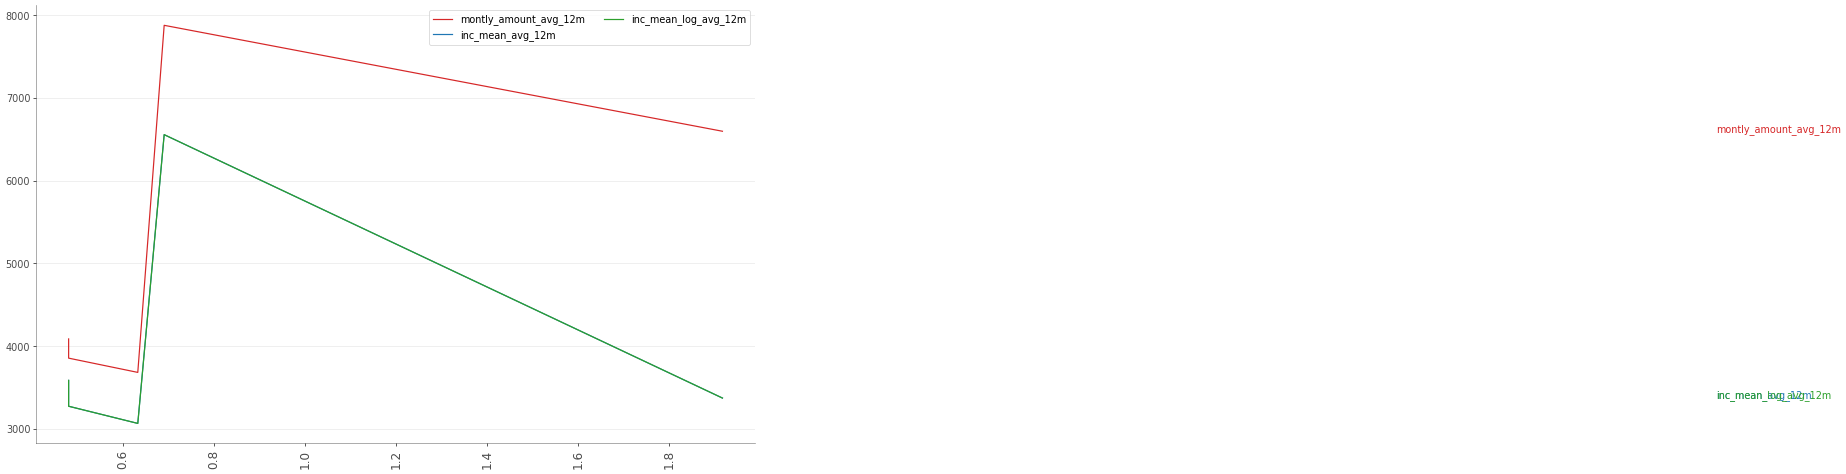

In [16]:
#is outlier 
plot_different_type_series(df_g.toPandas(), 
                           'ratio_sd_mean', 'movs','field', '', '',  dpi_value = 58, width = 16, height = 10, text_ = True)

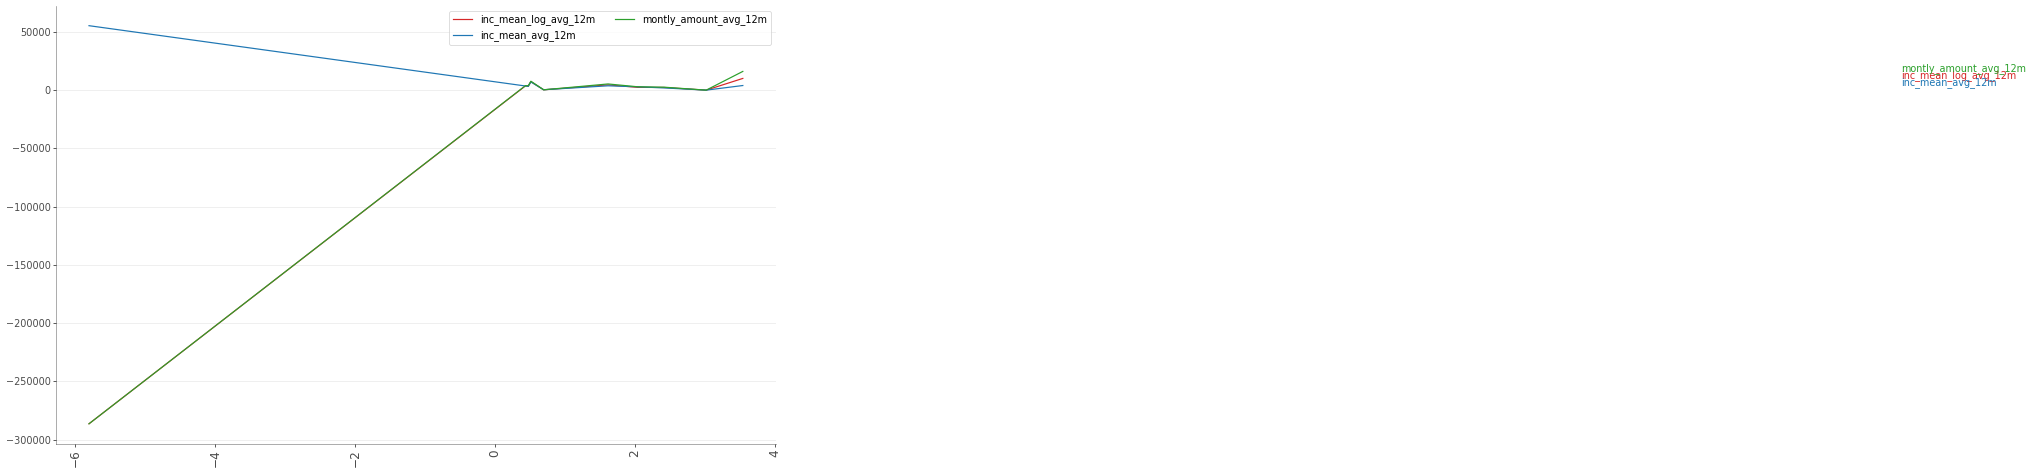

In [16]:
#is outlier 
plot_different_type_series(df_g.toPandas(), 
                           'ratio_sd_mean', 'movs','field', '', '',  dpi_value = 58, width = 16, height = 10, text_ = True)

In [ ]:
#is outlier 
df_g = df_g.withColumn('ratio_sd_mean',sf.when(col('ratio_sd_mean')< 0, (-1)*col('ratio_sd_mean') ).otherwise(col('ratio_sd_mean') ))
plot_different_type_series(df_g.toPandas(), 
                           'ratio_sd_mean', 'movs','field', '', '',  dpi_value = 58, width = 16, height = 10, text_ = True)

In [ ]:
#sustitute 
df_rolling_out = (df_rolling.withColumn('inc_mean', sf.when(col('monthly_partition')== '2021-03-31', col('rolling_avg_3m')).otherwise(col('montly_amount')))
                        .withColumn('inc_median', sf.when(col('monthly_partition')== '2021-03-31', col('rolling_median_3m')).otherwise(col('montly_amount')))
                                    .drop('rolling_avg_3m', 'list', 'rolling_median_3m', 'account_seniority_m', 'account_seniority_y', 'year', 'month'))

df_comparison = rolling_metric_12m(df_rolling_out, partitioned_by = "gf_customer_id", value = "montly_amount", date_field = "monthly_partition")
df_comparison = rolling_metric_12m(df_comparison, partitioned_by = "gf_customer_id", value = "inc_mean", date_field = "monthly_partition")
df_comparison = rolling_metric_12m(df_comparison, partitioned_by = "gf_customer_id", value = "inc_median", date_field = "monthly_partition")



In [ ]:
df_g = (to_explode(df_comparison.select('monthly_partition', 'gf_customer_id', 'montly_amount_avg_12m', 
                                      'inc_mean_avg_12m', 'mean', 'ratio_sd_mean', col('isOutlier').cast('double')), 
                   ['monthly_partition', 'gf_customer_id', 'mean', 'ratio_sd_mean', 'isOutlier'])) #, 'inc_median_avg_12m'
df_g = df_g.filter('''monthly_partition= '2021-03-31' ''') #

In [ ]:
df_g.show()

In [ ]:
#is outlier 
plot_different_type_series(df_g.toPandas(), 
                           'ratio_sd_mean', 'movs','field', '', '',  dpi_value = 58, width = 16, height = 10, text_ = True)